This notebook experiments with CPU and RAM efficient unsupervised learning techniques on the [CIC IoT 2023 dataset](https://www.kaggle.com/datasets/madhavmalhotra/unb-cic-iot-dataset). The aim is to identify patterns in normal network requests so that cyberattacks are easily distinguishable. 

The **messy data means I have to compare multiple clustering algorithms**. Here, I'll experiment with the [negative selection algorithm](https://www.youtube.com/watch?v=u2qRUtg2k3Y), [DBSCAN](https://www.youtube.com/watch?v=RDZUdRSDOok), and [k-means clustering](https://www.youtube.com/watch?v=4b5d3muPQmA).

In [1]:
import numpy as np
import pandas as pd

from functools import reduce
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Load Data

The entire dataset is 15 GB, so I'm using a downsampled version of the dataset that keeps 1% of the data while preserving class distributions.

In [2]:
df = pd.read_csv("/kaggle/input/creating-a-smaller-dataset-for-ciciot2023/0.01percent_2classes.csv")

Selecting features based on prior [importance analysis](https://www.kaggle.com/code/madhavmalhotra/genetic-algorithm-feature-selection)

In [3]:
X = df.loc[:, ["duration", "srate", "drate", "syn_flag_number", "psh_flag_number", "ack_flag_number", "ack_count", "syn_count", "rst_count", "header_length", "https", "ssh", "flow_duration", "avg", "max", "tot_sum", "min", "iat", "magnitude", "radius", "variance"]]
y = df.loc[:, ["benign"]]
X_ben = X.loc[(y == True).to_numpy().squeeze(-1), :]

Histograms to visualise the data distribution

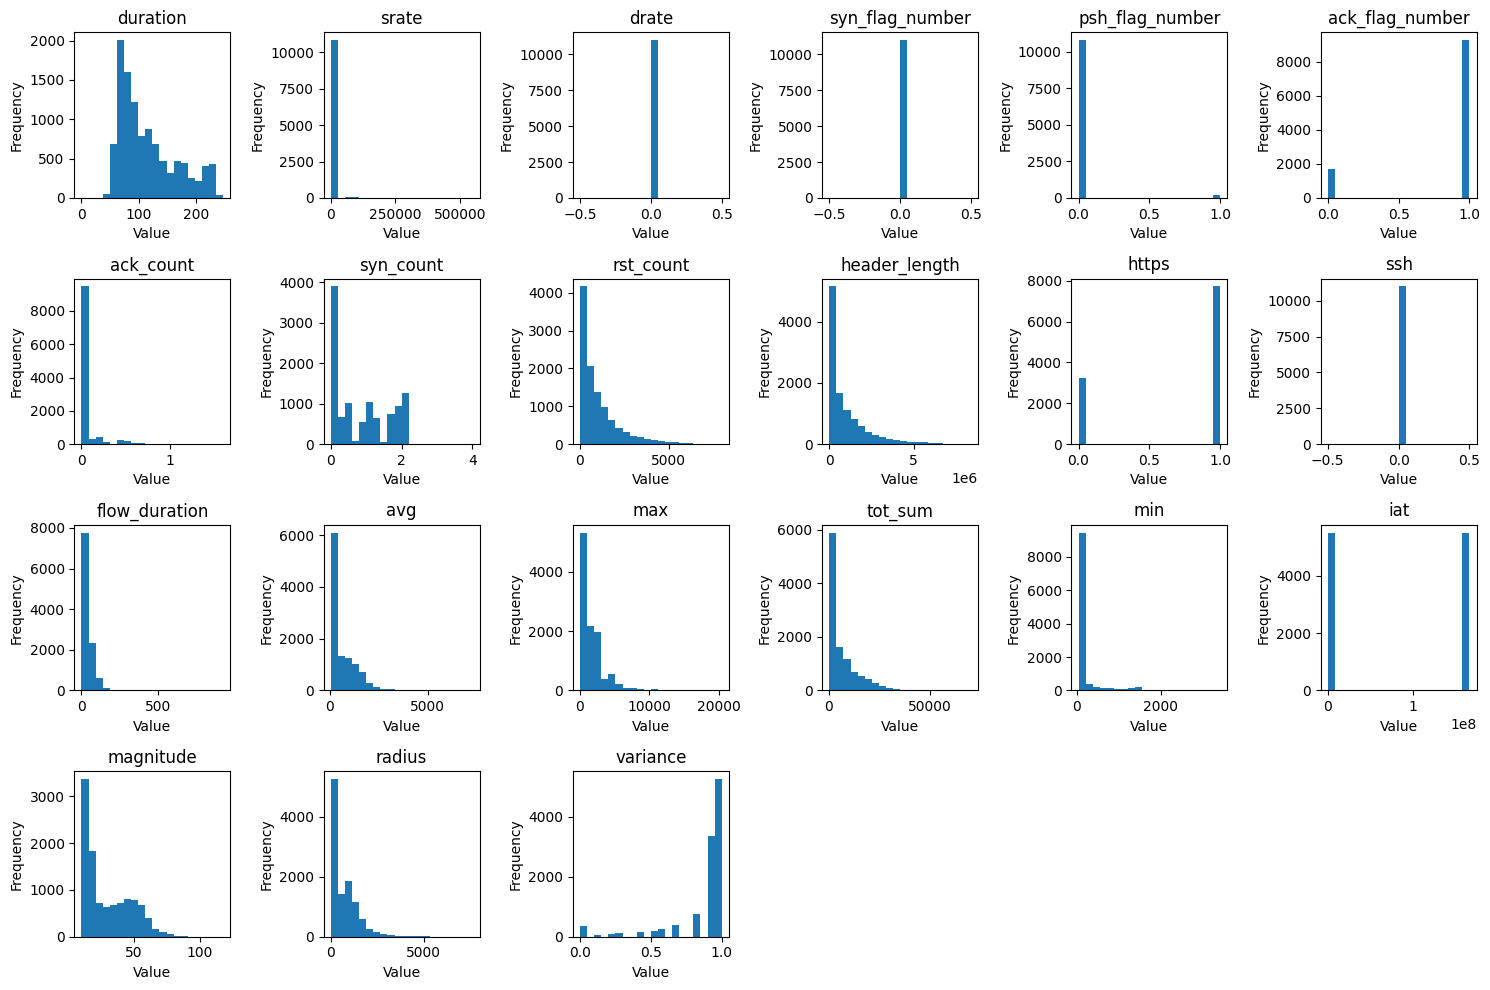

In [4]:
# Define the number of rows and columns in the grid
num_rows, num_cols = 4, 6

# Create a new figure and set the size
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

# Flatten the axes to iterate through them
axes = axes.ravel()

# Loop through each column and create a histogram on the corresponding axis
for i, col in enumerate(X_ben.columns):
    ax = axes[i]
    ax.hist(X_ben[col].astype(float), bins=20)  # You can adjust the number of bins as needed
    ax.set_title(col)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

# Hide empty subplots (index > num columns)
for i in range(len(X_ben.columns), num_rows * num_cols):
    fig.delaxes(axes[i])

# Adjust the layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

Boxplots to better visualise outliers (which aren't really visible in the large histogram y scale).

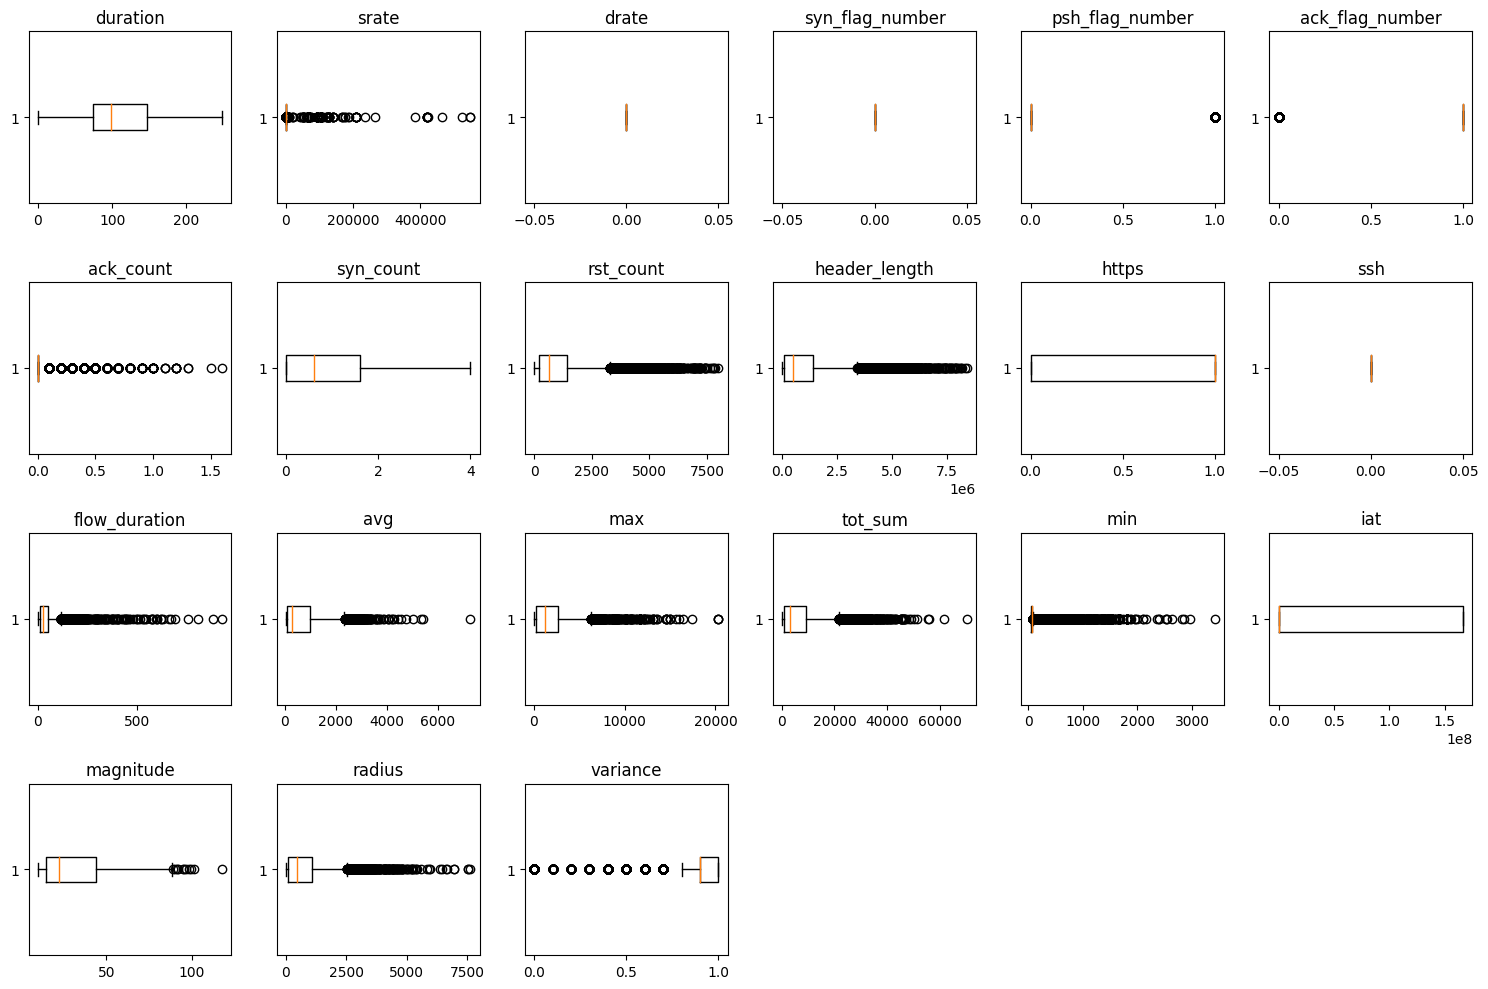

In [5]:
# Define the number of rows and columns in the grid
num_rows, num_cols = 4, 6

# Create a new figure and set the size
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

# Flatten the axes to iterate through them
axes = axes.ravel()

# Loop through each column and create a histogram on the corresponding axis
for i, col in enumerate(X_ben.columns):
    ax = axes[i]
    ax.boxplot(X_ben[col].astype(float), vert=False)  # Create a horizontal boxplot
    ax.set_title(col)

# Hide empty subplots (index > num columns)
for i in range(len(X_ben.columns), num_rows * num_cols):
    fig.delaxes(axes[i])

# Adjust the layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

Note: **features like iat and srate have long-tail/bimodal distributions**. This might make it hard to randomly initialise detectors, centroids, or core members (in negative selection algorithm, k-means clustering, or DBSCAN). 

If possible, I'd like to find an algorithm that handles this mess so I don't have to standardise features. Standardising the features would mean I have to save a mean and standard deviation from the dataset (which makes the algorithm less robust to distribution shifts in production). It also increases latency in a real-time application like approving or denying a network request.

In [6]:
# convert to numpy
X = X.to_numpy().astype(np.float32)
y = y.to_numpy().astype(np.float32)
benign_data = X[y.squeeze() == True, :]

print( X.shape, X.dtype, y.shape, y.dtype, benign_data.shape, benign_data.dtype )

(466657, 21) float32 (466657, 1) float32 (10984, 21) float32


# Negative Selection Algorithm (Naive)

Since the algorithm is randomly choosing vectors that are similar to 10000 other vectors, it's hard to select vectors that match all benign data well.

In [7]:
def affinity(v1 : np.ndarray, v2 : np.ndarray) -> float:
    ''' Euclidean distance between vectors '''
    return np.sqrt( np.sum((v1 - v2)**2, axis=-1) )

In [8]:
# To reduce repeated computation
HARDCODE_RANGE = np.max(benign_data, axis=0) - np.min(benign_data, axis=0) 

def gen_rand_like(dim : tuple, data = np.ndarray) -> np.ndarray:
    ''' 
    Generates random vectors with the same range as model data
    
    Parameters
    --------------
    dim: the dimensions of the random vectors to create.
    data: the benign data to get the range from (hardcoded for performance gains)
    '''
    
    return np.random.rand(*dim) * HARDCODE_RANGE

In [9]:
def improve_detectors(data : np.ndarray, detectors : np.ndarray, max_dist : float, 
                      max_iters : int) -> np.ndarray:
    
    # On every iteration, track average affinity between detectors and data
    aff_history = []
    for i in range(max_iters):
        print(".", end="")
        
        # Get affinity between all detectors and all data
        det_unsq = np.expand_dims(detectors, axis=1)
        aff = np.mean(affinity(det_unsq, data), axis=1)
        aff_history.append(np.mean(aff))
        to_remove = aff > max_dist
        
        # Update inefficient detectors
        new_det_shape = (np.sum(to_remove), detectors.shape[-1])
        detectors[to_remove, :] = gen_rand_like(new_det_shape, data)
        
    return detectors, aff_history

In [10]:
# Set hyperparameters
num_detectors = 250
max_dist = 8.2 * 10**7
max_iters = 25

# Gen random detectors
init_vec = gen_rand_like((num_detectors, benign_data.shape[-1]), benign_data)

# Improve detectors
detectors, aff_history = improve_detectors(benign_data, init_vec, max_dist, max_iters)

.........................

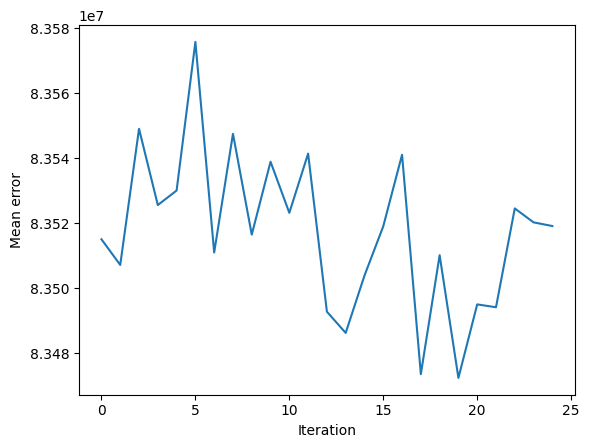

In [11]:
plt.xlabel("Iteration")
plt.ylabel("Mean error")
plt.plot(range(len(aff_history)), aff_history)

This is causing random fluctuations in performance essentially.

# Negative Selection Algorithm (Optimised)

We **don't need each detector to be close to each datapoint. We need the community of vectors overall to collectively cover every datapoint**. 

Potential implementations:
1. If any datapoint doesn't have detector within threshold, reset population. Forces exploration until detectors are sufficiently spread out. But can't distinguish between good and bad detectors within population.
2. If any detector has another detector within threshold, replace it. Selectively fixes detectors that are close together, but no incentive to make detectors close to datapoints.
3. If any detector has less than k datapoints within threshold, replace it. Selectively removes detectors far from datapoints, but could end up with all detectors in one place. 

Let's try 2 and 3. They're more precise. 


In [12]:
def improve_detectors_opt(data : np.ndarray, detectors : np.ndarray, 
                          det2det : float, dat2det : float, max_iters : int) -> np.ndarray:
    
    # On every iteration, track affinity
    aff_history = []
    for i in range(max_iters):
        print(".", end="")
        
        # Check distance between detectors
        aff = affinity(np.expand_dims(detectors, axis=1), detectors)
        second_lowest = np.partition(aff, 1, axis=1)[:, 1]
        to_remove = second_lowest < det2det
        
        # Update detectors that are too close
        new_det_shape = (np.sum(to_remove), detectors.shape[-1])
        detectors[to_remove, :] = gen_rand_like(new_det_shape, data)
        
        # Check datapoints without nearby detectors
        aff = affinity(np.expand_dims(data, axis=1), detectors)
        aff = np.min(aff, axis=1)
        aff_history.append(np.mean(aff))
        
        # Update random detectors to relocate to datapoint
        to_update = np.where(aff > dat2det)[0][: detectors.shape[0]]
        detectors[:to_update.shape[0]] = data[to_update, :]
    
    return detectors, aff_history

In [17]:
# Set hyperparameters
num_detectors = 250
det2det = 1 * 10**6
dat2det = 1 * 10**8
max_iters = 25

# Gen random detectors
init_vec = gen_rand_like((num_detectors, benign_data.shape[-1]), benign_data)

# Improve detectors
detectors, aff_history = improve_detectors_opt(benign_data, init_vec, det2det, dat2det, max_iters)

.........................

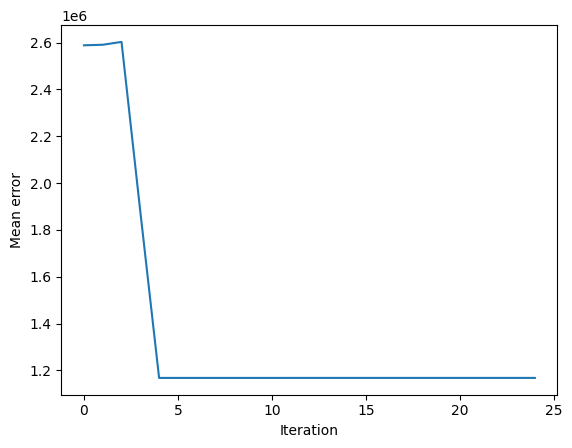

In [18]:
plt.xlabel("Iteration")
plt.ylabel("Mean error")
plt.plot(range(len(aff_history)), aff_history)

Not as random, but still not performing well. Though when we set detector vectors to just be a datapoint if a data point isn't covered - at this point the algorithm is just a poorly implemented k-means-clustering algorithm. 

So why not use normal k-means clustering? 

# K-means clustering

"K" is what we referred to as the number of detectors in the negative selection algorithm.

In [21]:
def k_means(data : np.ndarray, num_centroids : int, num_iters : int, 
            eps : float = 0.1, centr : np.ndarray=None) -> np.ndarray:
    '''
    Parameters
    ---------------
    data: shape num_examples x num_features.
    num_centroids: less than num_examples.
    num_iters: how many solutions to try. 
    eps: convergence threshold is when last_centroid - current_centroid < eps
    centr: initial values for centroids (ex: based on Kmeans++)
    
    Returns
    ---------------
    centroids: shape num_centroids x num_features
    '''
    
    # Fresh start (reset all centroids) on each iteration
    for i in range(num_iters):
        print(i)
        
        # Init random, prior, and best centroids
        if centr is None:
            centr = gen_rand_like((num_centroids, data.shape[-1]), data)
        prior = None
        best = None
        
        # Always perform at least one 
        while (True):
            print(".", end="")
            
             # Find centroids which are close to and not close to data
            groups = np.argmin(affinity(np.expand_dims(data, 1), centr), axis=1)
            has_data = np.unique(groups)
            has_no_data = np.setdiff1d(np.arange(centr.shape[0]), has_data, assume_unique=True)
            
            # Randomly replace centroids not close to data
            prior = centr.copy()
            centr[has_no_data, :] = gen_rand_like((has_no_data.shape[0], data.shape[-1]), data)
            
            # Update other centroids to be average of its datapoints  
            for i in range(has_data.shape[0]):
                points = data[np.where(groups == has_data[i]), :].squeeze(0)
                centr[i, :] = np.mean(points, axis=0)   
                    
            # If centroids not changing, stop
            if (affinity(prior, centr) < eps).all():
                break
            
        # Find the total distance for all datapoints to their centroids as a correlate of accuracy
        dist = np.sum( np.min(affinity(np.expand_dims(data, 1), centr), axis=1) )
        if (best is None) or (best[0] > dist):
            best = (dist, centr)
    
    # Return best accuracy centroids
    return best[-1] 

In [22]:
best_centr = k_means(benign_data, 5, 1, eps=1.0)
print(best_centr.shape)

0
............................................(5, 21)


I suspect the centroids aren't well initialised so the results aren't accurate. I say this since I saw that most dataset values were grouped under only a few centroids while debugging. 

To confirm my suspicions, I'll use a PCA visualisation.

In [23]:
pca = PCA(n_components=2)
data_pca = pca.fit_transform(benign_data)
data_labels = np.array([ np.argmin(affinity(d,best_centr)) for d in benign_data ])
centroids_pca = pca.transform(best_centr)

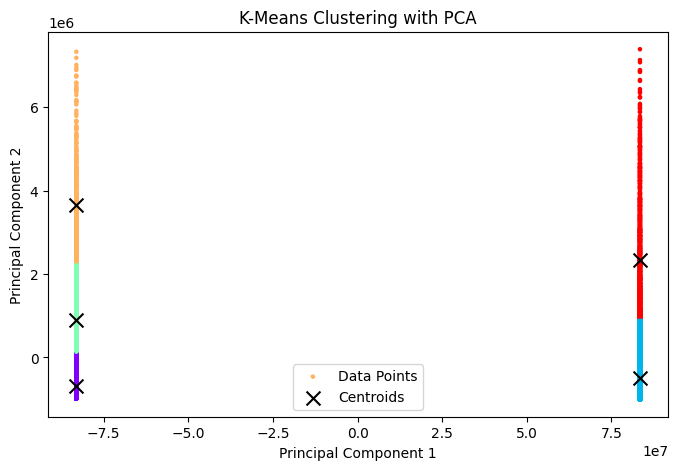

In [24]:
plt.figure(figsize=(8, 5))

# Scatterplot of the data
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=data_labels, cmap='rainbow', s=5, label="Data Points")

# Scatterplot of the centroids
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='black', marker='x', s=100, label="Centroids")

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("K-Means Clustering with PCA")
plt.legend()
plt.show()

The axes have ENORMOUS scale ranges, though it isn't the case that only a few centroids have all the labels. I think this suggests that **feature normalisation might be a larger problem than centroid initialisation**.

# Normalising Features

In [25]:
scaler = StandardScaler()
scaler.fit(benign_data)
ben_trans = scaler.transform(benign_data)
print(ben_trans.shape)

(10984, 21)


Histograms to visualise the new data

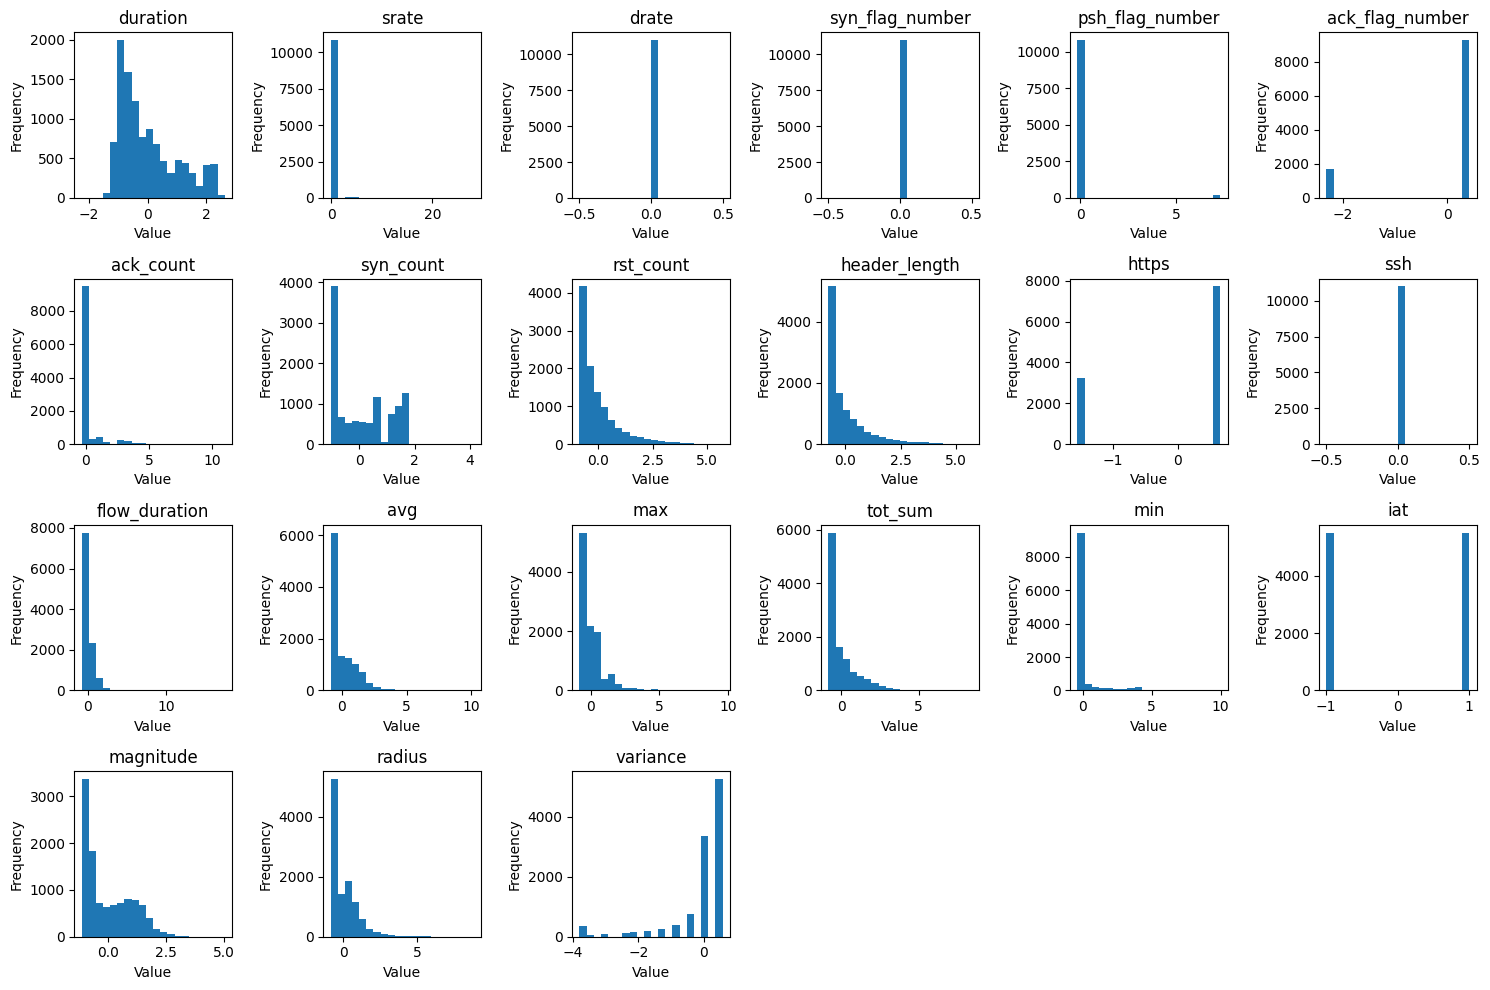

In [26]:
# Define the number of rows and columns in the grid
num_rows, num_cols = 4, 6

# Create a new figure and set the size
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

# Flatten the axes to iterate through them
axes = axes.ravel()

# Loop through each column and create a histogram on the corresponding axis
for i, col in enumerate(X_ben.columns):
    ax = axes[i]
    ax.hist(ben_trans[:, i].astype(float), bins=20)  # You can adjust the number of bins as needed
    ax.set_title(col)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

# Hide empty subplots (index > num columns)
for i in range(len(X_ben.columns), num_rows * num_cols):
    fig.delaxes(axes[i])

# Adjust the layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

Next, I'd like to retry k-means clustering with [k-means++ initialisation](https://www.geeksforgeeks.org/ml-k-means-algorithm/). 

K-means++ will centre centroids away from existing clusters. However, there are outliers in some features. This would lead to a high probability of outliers skewing centroid initialisation. So I'll use [DBSCAN](https://www.youtube.com/watch?v=RDZUdRSDOok) to identify core points vs. outliers. 

# DBSCAN

In [27]:
# Stored to avoid repeated computations
unsq = ben_trans.reshape(ben_trans.shape[0], 1, ben_trans.shape[1])
AFFINITY_LOOKUP = affinity(ben_trans, unsq)

print(AFFINITY_LOOKUP.shape)
del unsq

(10984, 10984)


In [28]:
def check_nearby_points(base : int, core_points : np.ndarray, border_points : np.ndarray, 
                        indices: np.ndarray, near_stats : np.ndarray) -> list:
    '''
    Recursively checks points near an initial base point.
    
    Parameters
    -------------------
    base: index of base point.
    core_points: indices of all core points. dim: num_core
    border_points: indices of all border points. dim: num_border
    indices: indices of all nearby points. dim: num_points_in_cluster
    near_stats: whether each pair of points is nearby. dim: num_datapoints x num_datapoints
    
    Returns
    -------------------
    Updated core_points, border_points, and indices
    '''
    
    # Find nearby points
    nearby = np.where(near_stats[base, :])[0]
    new_core = np.intersect1d(nearby, core_points, assume_unique=True)
    new_border = np.intersect1d(nearby, border_points, assume_unique=True)  
    
    # Stop tracking discovered points. Add those to cluster
    core_points = np.setdiff1d(core_points, new_core, assume_unique=True)
    border_points = np.setdiff1d(border_points, new_border, assume_unique=True)
    indices = reduce(np.union1d, (indices, new_core, new_border)) 
    
    # when new core points discovered, recurse
    print(".", end="")
    if new_core.shape[0]:
        for i in range(new_core.shape[0]): 
            core_points, border_points, indices = \
                check_nearby_points(new_core[i], core_points, border_points, indices, near_stats)
            
    return core_points, border_points, indices

In [29]:
def dbscan(data : np.ndarray, min_core : int, radius : float, dist : np.ndarray) -> dict:
    '''
    Parameters
    ----------------
    data: all data points. dim: num_datapoints x num_features
    min_core: num points nearby to count as core. Raise to decrease clusters
    radius: how far to search for nearby points. Lower for more similar clusters
    dist: distances between all datapoints. dim: num_datapoints x num_datapoints
    
    Returns
    ----------------
    cats: dict storing numpy arrays of datapoints by category/class keys
    '''
    
    # Categorise points
    near = dist < radius
    counts = np.sum(near.astype(int), axis=0) - 1 
    
    core = np.where(counts >= min_core)[0]
    outliers = np.where(counts == 0)[0]
    border = np.where((counts > 0) & (counts < min_core))[0]
    
    cats = {'core': core, 'border': border, 'outliers': outliers}
    print([(k,v.shape) for k,v in cats.items()])
    
    # If there are core points not assigned clusters, form new clusters.
    while cats['core'].shape[0]:
        print(str( len(cats.keys()) + 1))
        
        # Pick random core point as start
        k = np.random.choice(cats['core'].shape[0]) 
        idx = cats['core'][k]
        cats['core'] = np.delete(cats['core'], k, axis=0)
        
        # Find other points around that
        indices = np.array([idx])
        cats['core'], cats['border'], indices = \
            check_nearby_points(idx, cats['core'], cats['border'], indices, near)
        cats[str( len(cats.keys()) + 1)] = indices
    
    # When no more unassigned core points, return clustered points and outliers. 
    return cats

In [30]:
cats = dbscan(ben_trans, 25, 1.4, AFFINITY_LOOKUP)

[('core', (7178,)), ('border', (3210,)), ('outliers', (596,))]
4
........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................5
.............................................................................................................................................................................................................................................................................................................................................................................................................................................

In [31]:
print([(k,v.shape) for k,v in cats.items()])

[('core', (0,)), ('border', (1622,)), ('outliers', (596,)), ('4', (615,)), ('5', (665,)), ('6', (634,)), ('7', (3043,)), ('8', (3028,)), ('9', (756,)), ('10', (25,))]


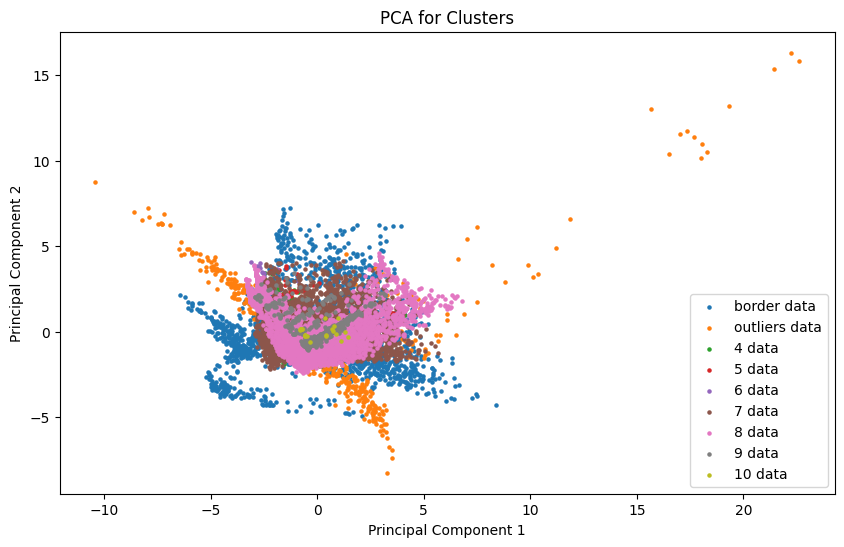

In [32]:
# Create a scatterplot of the clustered data
plt.figure(figsize=(10, 6))

# Skip empty categories
for k,v in cats.items():
    if not v.shape[0]:
        continue
    
    # Plot reduced dimension datapoints
    trans = pca.fit_transform(ben_trans[v, :])
    plt.scatter(trans[:, 0], trans[:, 1], s=5, label=f'{k} data')

plt.legend()
plt.title('PCA for Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

Now that I've removed outliers from the dataset, I can run K-means++ initialisation without a high probability of centroids being initialised at outliers.

# K-means++

In [33]:
def init_centr(data : np.ndarray, num_centr : int, old_centr : np.ndarray) -> np.ndarray:
    '''
    Initialises centroids as datapoints, usually those which are far from current data
    '''
    
    # No current centroids, pick one randomly
    if old_centr is None and num_centr > 0:
        idx = np.random.randint(data.shape[0])
        old_centr = data[idx:idx+1, :]
    else:
        # Compute distance between each point and closest centroids 
        view = data.reshape((data.shape[0], 1, data.shape[-1]))
        dist = np.min(affinity(view, old_centr), axis=-1)
        dist = dist / np.sum(dist)
        
        # Pick centroid
        idx = np.random.choice(data.shape[0], 1, p=dist)[0]
        old_centr = np.concatenate((old_centr, data[idx:idx+1, :]))
    
    # If more computation needed
    if num_centr > old_centr.shape[0]:
        old_centr = init_centr(np.delete(data, idx, axis=0), num_centr, old_centr)
    
    # Return centroids
    return old_centr

In [34]:
no_outliers = np.concatenate(
    [ben_trans[v, :] for k,v in cats.items() if k not in ["core", "outliers"]]
)

print('Filtered: ', no_outliers.shape, '. Original: ', ben_trans.shape)

Filtered:  (10388, 21) . Original:  (10984, 21)


In [35]:
start_centr = init_centr(no_outliers, 8, None)
print(start_centr.shape)

(8, 21)


In [36]:
best_centr = k_means(no_outliers, 8, 1, eps=0.00001, centr=start_centr)
print(best_centr.shape)

0
..............................(8, 21)


In [37]:
data_pca = pca.fit_transform(no_outliers)
data_labels = np.array([ np.argmin(affinity(d,best_centr)) for d in no_outliers ])
centroids_pca = pca.transform(best_centr)

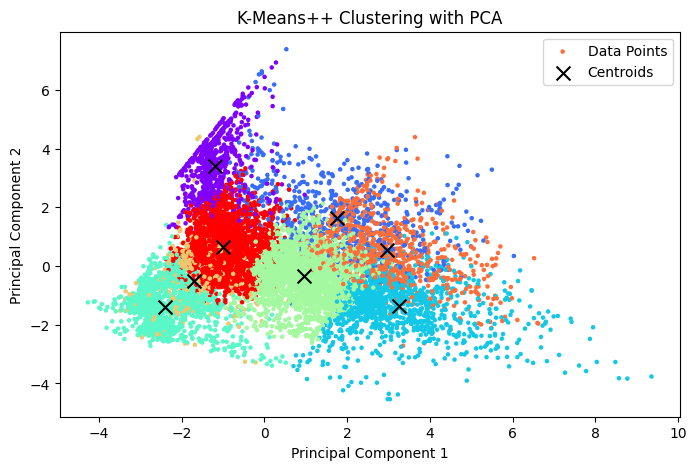

In [38]:
plt.figure(figsize=(8, 5))

# Scatterplot of the data
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=data_labels, cmap='rainbow', s=5, label="Data Points")

# Scatterplot of the centroids
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='black', marker='x', s=100, label="Centroids")

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("K-Means++ Clustering with PCA")
plt.legend()
plt.show()